## About 

Select subjects based on regions of interest


In [2]:
import sys
import os
root_folder = "./../"

import getopt
import numpy as np
import multiprocessing # todo
from os.path import join as ospj
import sys
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import iirnotch, filtfilt, butter, lfilter, medfilt

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, date, timedelta
import importlib

from scipy import signal
from scipy.signal import butter, lfilter, freqz, filtfilt, find_peaks, medfilt, ellip
from scipy.signal import savgol_filter, hilbert
import scipy.io

import seaborn as sns
# import mne

In [ ]:
#load trial details from matfile
mat = scipy.io.loadmat('./../tools/patient_localization_final.mat')

idx = []
for i in range(len(mat['patient_localization'][0])):
    rem = []
    res = []
    loc = []
    reg = []
    s = int(mat['patient_localization'][0][i][0][0][-3:])
    if s in subject_list:
        for j in range(len(channels[s])):
            rem.append(mat['patient_localization'][0][i][2][j][0])
            res.append(mat['patient_localization'][0][i][3][j][0])
            reg.append(mat['patient_localization'][0][i][6][j][0])
            loc.append(mat['patient_localization'][0][i][5][j])
        rem= np.array(rem)

        rem_elec[s] = np.where(rem==1)[0]
        res = pd.DataFrame(res)
        reg = pd.DataFrame(reg)
        loc = pd.DataFrame(loc)
        
        res = res.drop(rem_elec[s])
        reg = reg.drop(rem_elec[s])
        loc = loc.drop(rem_elec[s])
        
        res = res.reset_index(drop=True)
        elec_reg[s] = reg.reset_index(drop=True)
        elec_loc[s] = loc.reset_index(drop=True)
        
        resc_elec[s] = np.where(res.values==1)[0]

        
        

        

In [206]:
#get regions of interest
ec_regions = ['INS', 'AMY', 'CING', 'HIP', 'OFC']
atlas_regions = pd.read_csv("regions_hrv_correlation - Sheet1.csv")

In [207]:
region_id = atlas_regions[atlas_regions['Select']==1]['regionID'].values

In [209]:
region_id

array([31, 62, 68, 77,  8, 21, 40, 53,  1, 24, 33, 56, 14, 46, 67, 76, 12,
       42, 44, 10])

In [210]:
# load location mat file
mat = scipy.io.loadmat('elecs2ROI_with_hemisphere.mat')

In [211]:
sub_id = []
for sub in range(len(mat['elec2ROIOut'])):
    sub_id.append(mat['elec2ROIOut'][sub][0][0][0][0])


region_count =  pd.DataFrame(columns=region_id, index = sub_id)

In [212]:
for sub in range(len(mat['elec2ROIOut'])):
    sub_name = mat['elec2ROIOut'][sub][0][0][0][0]
    table = pd.DataFrame(mat['elec2ROIOut'][sub][1].reshape(-1))

    temp_ = np.concatenate((table['roi'].values),axis=0).reshape(-1)

    for reg in region_id:
        region_count.loc[sub_name,reg] = np.count_nonzero(temp_ ==reg)>0
    
    

In [213]:
region_count

,31,62,68,77,8,21,40,53,1,24,33,56,14,46,67,76,12,42,44,10
HUP060,False,True,False,True,False,False,False,False,False,True,True,True,False,True,False,True,False,True,False,False
HUP064,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True
HUP065,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
HUP068,False,False,False,False,False,True,False,True,True,False,True,False,False,True,False,False,False,False,False,False
HUP070,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HUP185,True,False,True,True,False,True,False,False,True,True,False,False,True,True,True,True,False,False,False,False
HUP187,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,False
HUP188,True,False,True,True,True,True,True,False,True,True,False,False,False,True,True,True,False,False,False,False
HUP190,True,True,True,True,True,True,False,False,True,True,False,False,True,True,True,True,True,False,False,True


In [224]:
maj_region_count = pd.DataFrame(columns = ec_regions, index = sub_id)

In [228]:
for n,c in enumerate(ec_regions):
    regions = atlas_regions[atlas_regions['Region Num']==n+1]['regionID'].values
    maj_region_count[c] = region_count[regions].sum(axis=1)>0


In [229]:
maj_region_count

,INS,AMY,CING,HIP,OFC
HUP060,True,True,False,True,True
HUP064,False,False,True,True,False
HUP065,False,False,False,False,False
HUP068,False,False,True,True,True
HUP070,False,False,False,False,False
...,...,...,...,...,...
HUP185,True,True,True,True,True
HUP187,True,True,False,False,True
HUP188,True,True,True,True,True
HUP190,True,True,True,True,True


## plot histogram of distributions

In [240]:
x.index

Index(['INS', 'AMY', 'CING', 'HIP', 'OFC'], dtype='object')

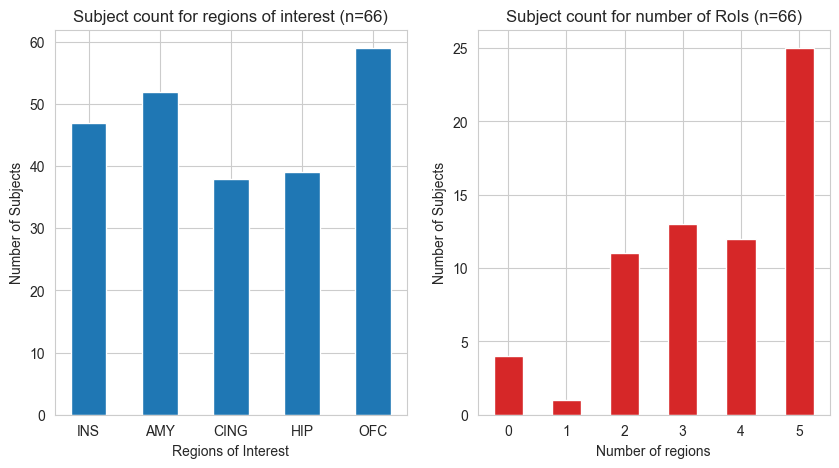

In [285]:

sns.set_style('whitegrid')

fig, ax = plt.subplots(1,2, figsize = [10,5])
fig.patch.set_facecolor('xkcd:white')

axi = ax[0]
x = maj_region_count.sum(axis=0)
axi.bar(x.index, x.values,width = 0.5)
axi.set_xlabel("Regions of Interest")
axi.set_ylabel("Number of Subjects")
axi.set_title("Subject count for regions of interest (n=66)")



axi = ax[1]
x = maj_region_count.sum(axis=1)
axi.hist(x, color = 'C3', bins=np.arange(7)-0.5, align='mid',rwidth = 0.5)
axi.set_xlabel("Number of regions")
axi.set_ylabel("Number of Subjects")
axi.set_title("Subject count for number of RoIs (n=66)")



plt.savefig("./subjects_roi_check.png", dpi = 300, bbox_inches='tight')
plt.show()